## Image Captioning
- Generating voice for a caption
- Converting voice from a image 
- Image --> caption --> voice

### Steps 
- Data collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing — Images
- Data Preprocessing — Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference
- Predictions
- Voice conversion from caption

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras#Keras is a deep learning API written in Python, running on top of the machine learning platform TensorFlow.
import re#This module provides regular expression
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.
D:\Python\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Python\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Python\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Python\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synon

In [2]:
# Read Text Captions
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions 

In [3]:
captions  = readTextFile("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]#Last line is basically empty so we can discard that  

### Total captions in the dataset

In [4]:
print(len(captions))

40460


In [5]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [6]:
captions[0].split("\t")

['1000268201_693b08cb0e.jpg#0',
 'A child in a pink dress is climbing up a set of stairs in an entry way .']

In [7]:
first,second  = captions[0].split('\t')
print(first)
print(second)

1000268201_693b08cb0e.jpg#0
A child in a pink dress is climbing up a set of stairs in an entry way .


In [8]:
first,second  = captions[0].split('\t')
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [9]:
# Dictionary to Map each Image with the list of captions it has

Making descriptions as a record for the imageid and caption

In [10]:
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)

In [11]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

### Image visualisation

In [12]:
!pip install opencv-python

In [13]:
##Reading the image

In [14]:
import cv2

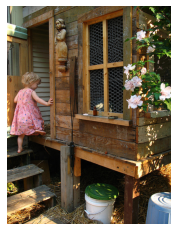

In [15]:
IMG_PATH = "Flickr_Data/Flickr_Data/Images"

img = cv2.imread(IMG_PATH+"/1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

### Data Cleaning


In [16]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)#using regular expression to remove the punctuation marks and other numbers#regular expression to substitute
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence   

In [17]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [18]:
# Clean all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [19]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [20]:
# Write the data to text file to store for the future use
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

### Vocabulary 

In [21]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")#making json acceptable string
descriptions = json.loads(json_acceptable_string)#converting the stirng in dictionary 

In [22]:
# since there is a very large dataset hence we are storing in a file and it take time in  preprocessing so it is better choice
# to make a sep file for the descriptions

In [23]:
print(type(descriptions))

<class 'dict'>


In [24]:
voc = set()
voc.update(["apoorv"])
voc.update(["excellent","ajay","muna"])
voc.update(["apoorv"])
print(voc)

{'excellent', 'apoorv', 'muna', 'ajay'}


In [25]:
# Vocab Creation
vocab = set() #set basically store all the unique words
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [26]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))


Total Words 373837


In [27]:
# Filter Words from the Vocab according to certain threshold frequncy

In [28]:
import collections#container data types called Collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)#freq_cnt give the dictionary of all the words with there occurences
print(len(freq_cnt.keys()))

8424


In [29]:
counter

Counter({'child': 1545,
         'in': 18987,
         'pink': 739,
         'dress': 348,
         'is': 9345,
         'climbing': 507,
         'up': 1302,
         'set': 109,
         'of': 6723,
         'stairs': 109,
         'an': 2432,
         'entry': 1,
         'way': 53,
         'girl': 3328,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 511,
         'little': 1768,
         'playhouse': 6,
         'the': 18420,
         'to': 3176,
         'her': 1178,
         'cabin': 4,
         'black': 3848,
         'dog': 8138,
         'and': 8863,
         'spotted': 38,
         'are': 3505,
         'fighting': 133,
         'tri': 14,
         'colored': 221,
         'playing': 2008,
         'with': 7765,
         'each': 430,
         'other': 773,
         'on': 10746,
         'road': 398,
         'white': 3959,
         'brown': 2578,
         'spots': 29,
         'staring': 57,
         'at': 2916,
         'street': 

In [30]:
type(counter)#we chnange this into type freq_cnt

collections.Counter

In [31]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [32]:
print(len(total_words))#form 3 lakh words finally we have filtered it to 2k words whose frequency is greater than 10 

1845


### Inetial 373837 --> 8424 --> Final Vocab size 1845

### Prepare Train/Test Data

In [33]:
train_file_data = readTextFile("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [34]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [35]:
train[:10]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079',
 '2699342860_5288e203ea',
 '2638369467_8fc251595b',
 '2926786902_815a99a154']

In [36]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [37]:
train_descriptions["2513260012_03d33305cf"]

['startseq black dog is running after white dog in the snow endseq',
 'startseq black dog chasing brown dog through snow endseq',
 'startseq two dogs chase each other across the snowy ground endseq',
 'startseq two dogs play together in the snow endseq',
 'startseq two dogs running through low lying body of water endseq']

### Transfer Learning
- Images --> Features
- Text ---> Features 

### Step - 1 Image Feature Extraction

In [38]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________

In [39]:
model.layers[-2].output

<tf.Tensor 'avg_pool/Mean:0' shape=(?, 2048) dtype=float32>

In [40]:
model_new = Model(model.input,model.layers[-2].output)

In [41]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


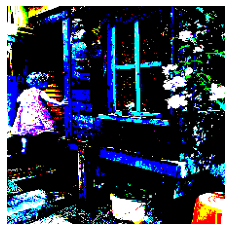

In [42]:
imgi = preprocess_img(IMG_PATH+"/1000268201_693b08cb0e.jpg")
plt.imshow(imgi[0])
plt.axis("off")
plt.show()
##This image is not clearly visble to us but this is how it is fed to resent dont worry for the pixel because while preprocessin
#it automatically clips between 0 to 255  here it is visble like this bcoz form each pixel we have subtracted the channel mean
##This is how the image look after preprocessing 

In [43]:
print(imgi)
print(imgi.shape)

[[[[ -30.939003   -61.779      -67.68     ]
   [  13.060997     6.2210007  -17.68     ]
   [  34.060997    32.221        5.3199997]
   ...
   [ -99.939     -116.779     -118.68     ]
   [ -98.939     -111.779     -118.68     ]
   [-101.939     -108.779     -120.68     ]]

  [[ -36.939003   -68.779      -72.68     ]
   [  21.060997     9.221001   -13.68     ]
   [  38.060997    37.221        8.32     ]
   ...
   [ -94.939     -104.779     -113.68     ]
   [ -93.939     -108.779     -116.68     ]
   [ -90.939      -86.779     -102.68     ]]

  [[ -39.939003   -74.779      -76.68     ]
   [  26.060997    13.221001    -9.68     ]
   [  41.060997    36.221        6.3199997]
   ...
   [ -99.939     -107.779     -115.68     ]
   [-101.939     -107.779     -121.68     ]
   [ -95.939     -101.779     -123.68     ]]

  ...

  [[ -27.939003    56.221      107.32     ]
   [ -92.939      -49.779       20.32     ]
   [ -49.939003   -13.778999    35.32     ]
   ...
   [ 150.061      132.22101    126.

In [44]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))#THis reshape is done because image is feed to the final network in the form 
    #of 4d tensor or batches is also pressent so here bydefalut it will become 1,
    #print(feature_vector.shape)
    return feature_vector

In [45]:
encode_image(IMG_PATH+"/1000268201_693b08cb0e.jpg")

array([0.04154286, 0.17076087, 0.2927856 , ..., 0.05089605, 0.31322372,
       0.8600747 ], dtype=float32)

In [46]:
len(train)

6000

In [55]:
# start = time()
# encoding_train = {}
# #image_id -->feature_vector extracted from Resnet Image

# for ix,img_id in enumerate(train):
#     img_path = IMG_PATH+"/"+img_id+".jpg"
#     encoding_train[img_id] = encode_image(img_path)
    
#     if ix%100==0:
#         print("Encoding in Progress Time step %d "%ix)
        
# end_t = time()
# print("Total Time Taken :",end_t-start)


In [56]:
# !mkdir saved

In [57]:
# # Store everything to the disk 
# with open("saved/encoded_train_features.pkl","wb") as f:
#     pickle.dump(encoding_train,f)

In [58]:
# start = time()
# encoding_test = {}
# #image_id -->feature_vector extracted from Resnet Image

# for ix,img_id in enumerate(test):
#     img_path = IMG_PATH+"/"+img_id+".jpg"
#     encoding_test[img_id] = encode_image(img_path)
    
#     if ix%100==0:
#         print("Test Encoding in Progress Time step %d "%ix)
        
# end_t = time()
# print("Total Time Taken(test) :",end_t-start)

In [59]:
# with open("saved/encoded_test_features.pkl","wb") as f:
#     pickle.dump(encoding_test,f)

In [60]:
with open("./saved/encoded_train_features.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [61]:

with open("./saved/encoded_test_features.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [64]:
#encoding_test

### Data pre-processing for Captions

In [65]:
# Vocab
len(total_words)

1845

In [66]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1#we dont want to map with 0 index 
    idx_to_word[i+1] = word

In [67]:
#word_to_idx["dog"]
#idx_to_word[1]
print(len(idx_to_word))

1845


In [68]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1 #0 index is also included here 
print("Vocab Size",vocab_size) 

Vocab Size 1848


In [69]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


## https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

### Data Loader (Generator)

In [70]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorcial([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

## Word Embeddings 

In [71]:
f = open("./saved/glove.6B.50d.txt",encoding='utf8')

In [72]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    

In [73]:
f.close()

In [74]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [75]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix
        
    

In [76]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [77]:
#embedding_matrix[1847]

#### Model Architecture

In [78]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [79]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [80]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [81]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [82]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [83]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

### Training of Model

In [69]:
#epochs = 20
# batch_size = 3
# steps = len(train_descriptions)//10
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

# Trained this model on google collab and saved the wights to work in my local pc

In [70]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [84]:
model = load_model('./model_weights/model_9.h5')

## Predictions

In [85]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

white dog is running through the snow


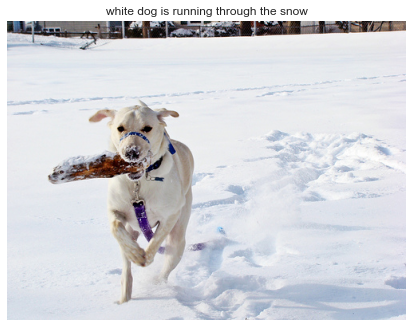

brown and white dog is standing in the water


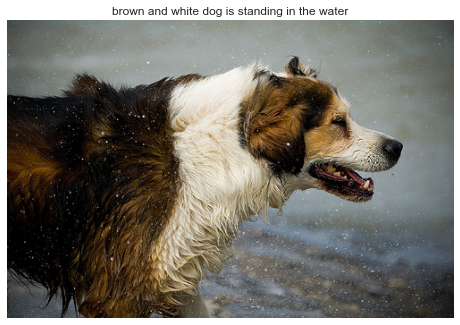

dog jumps over hurdle


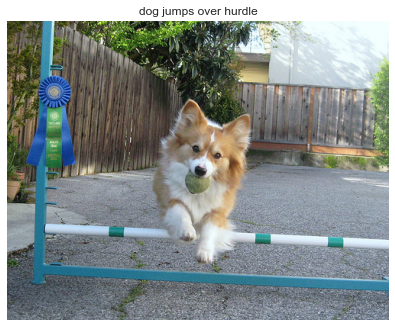

two men in coats are standing on rock overlooking forest


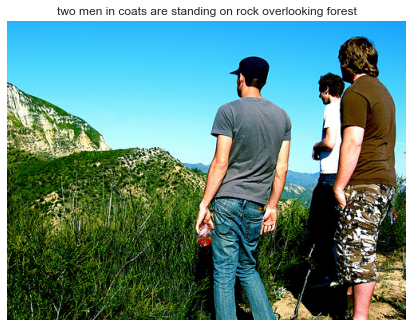

little girl in white shirt and blue shirt is running on the grass


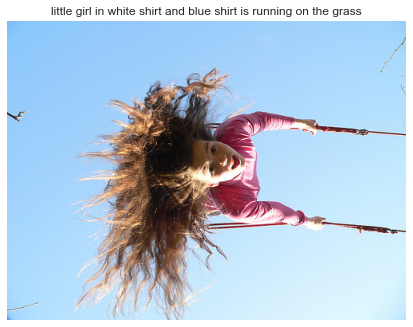

man and woman sit on bench in front of restaurant


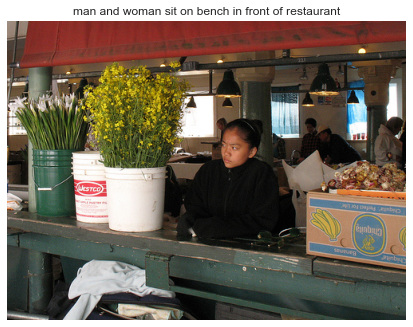

young girl in green shirt and blue shorts is standing on the grass


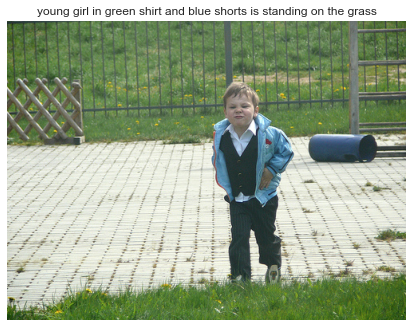

man is flying in the air on the beach


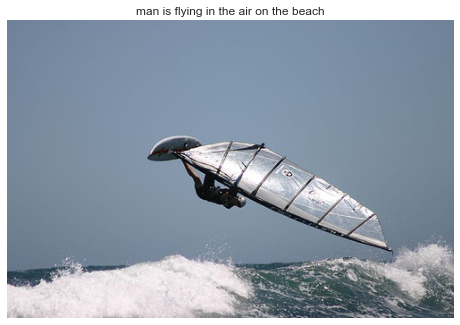

two people are standing on snowy mountain


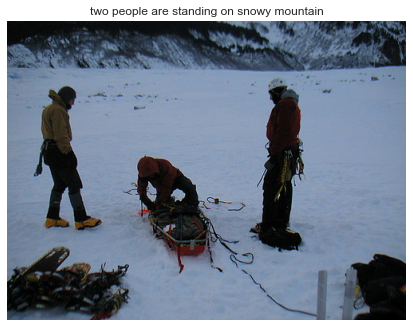

two girls are playing on the street


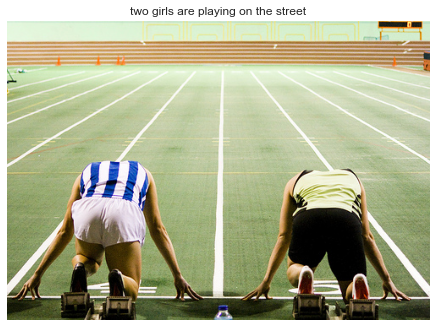

group of people are standing in front of crowd


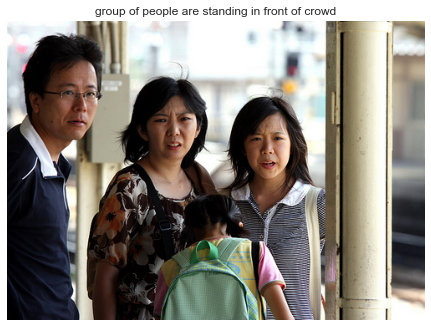

dog is running on the grass


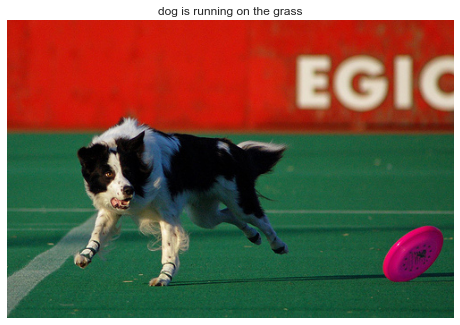

two dogs are playing soccer in field


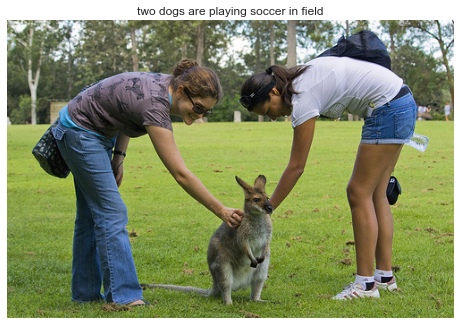

boy in blue shirt and blue shorts is jumping on trampoline


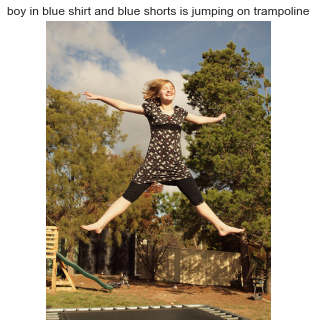

two dogs are running through the grass


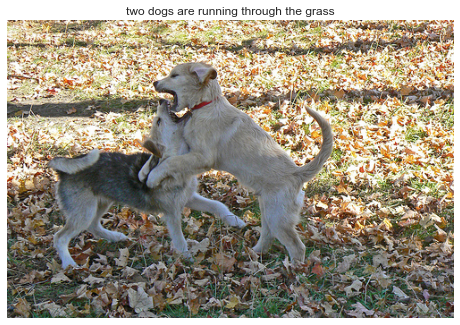

In [88]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    

In [89]:
!pip install gtts

## CONVERTING TEXT IN AUDIO

In [90]:
from gtts import gTTS 
import os 

## USE CASE : BLIND HELPER SOFTWARE 
## Final Result

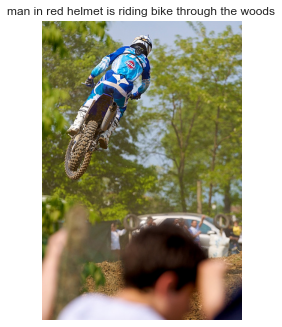

In [95]:
idx = np.random.randint(0,1000)
all_img_names = list(encoding_test.keys())
img_name = all_img_names[idx]
photo_2048 = encoding_test[img_name].reshape((1,2048))
    
i = plt.imread("Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")
    
caption = predict_caption(photo_2048)
mytext = caption
language = 'en'
myobj = gTTS(text=mytext, lang=language, slow=True) 
myobj.save("output.mp3") 
os.system("start output.mp3") 
plt.title(caption)
plt.imshow(i)
plt.axis("off")
plt.show()